In [1]:
from keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras


D:\Anaconda\envs\tf-gpu\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import tensorflow as tf
from keras.layers import Activation
from keras.utils.generic_utils import get_custom_objects
from keras import backend as K
from keras.layers import Conv2D, Lambda, MaxPooling2D, BatchNormalization, concatenate, GlobalAveragePooling2D, Dense
from keras.models import Model
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt 
import time

In [3]:
from keras.preprocessing.image import ImageDataGenerator
train_dataset = ImageDataGenerator(rescale=1./255)
test_dataset = ImageDataGenerator(rescale=1./255)
validation_dataset = ImageDataGenerator(rescale=1./255)


#BATCH_SIZE = 32
#IMG_SIZE = (160, 160)
#train_dir='Database/Train/'
#validation_dir='Database/Valid/'
#train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            #shuffle=True,
                                                            #batch_size=BATCH_SIZE,
                                                            #image_size=IMG_SIZE)
#validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                # shuffle=True,
                                                                # batch_size=BATCH_SIZE,
                                                                 #image_size=IMG_SIZE)
#import tensorflow as tf
#AUTOTUNE = tf.data.AUTOTUNE

#train_dataset= train_dataset.prefetch(buffer_size=AUTOTUNE)
#validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
#test_datagen = test_datagen.prefetch(buffer_size=AUTOTUNE)
 
batchsize = 10
train_generator=train_dataset.flow_from_directory('ieee/train/', 
                                                  target_size=(224, 224), 
                                                  batch_size=batchsize, 
                                                  class_mode='categorical')
 
validation_generator = validation_dataset.flow_from_directory('ieee/val/',
        target_size=(224, 224),
        batch_size=batchsize,
        class_mode='categorical',
        shuffle=False)
test_generator = test_dataset.flow_from_directory('ieee/test/',
       target_size=(224, 224),
       batch_size=batchsize,
       class_mode='categorical',
       shuffle=False)

Found 784 images belonging to 2 classes.
Found 448 images belonging to 2 classes.
Found 171 images belonging to 2 classes.


# Model Creation
VGG Net: VGG network has simplest structure with 3 x 3 filter in each convolutional layer. There are two variant available VGG-16 and VGG1-9. In the image above VGG network is presneted.
Transfer Learning: The VGGNet pre-trained on ImageNet and Inception module for transfer learning, and trained the newly formed neural networks using new datasets. The approach combines the advantages of the VGGNet and Inception module.

In [4]:
#DENSENET121
base_model1=keras.applications.DenseNet121(
    include_top=True, weights="imagenet", input_tensor=None, 
    input_shape=None, pooling=None,classes=1000,
    #classifier_activation='softmax'
)

#DenseNet169
base_model2=keras.applications.DenseNet169(
    include_top=True, weights="imagenet", input_tensor=None, 
    input_shape=None, pooling=None,classes=1000,
    #classifier_activation='softmax'
)


#VGG19
base_model3=keras.applications.vgg19.VGG19(
    include_top=True, weights='imagenet', input_tensor=None,
    input_shape=None, pooling=None, classes=1000,
    classifier_activation='softmax'
)

#MobileNet
base_model4=tf.keras.applications.MobileNetV2(
    include_top=True, weights='imagenet', input_tensor=None,
    input_shape=None, pooling=None, classes=1000,
    classifier_activation='softmax'
)

#ResNet50 
base_model5 = tf.keras.applications.resnet50.ResNet50(
    include_top=True, weights='imagenet', input_tensor=None,
    input_shape=None, pooling=None, classes=1000,
    classifier_activation='softmax')

#Inception V3
base_model6=tf.keras.applications.InceptionV3(
    include_top=True, weights="imagenet", input_tensor=None,
    input_shape=None, pooling=None, classes=1000,
    classifier_activation="softmax",
)




## setting all layers as non-trainable

In [5]:
for layer in base_model1.layers:
    layer.trainable=False
for layer in base_model2.layers:
    layer.trainable=False
for layer in base_model3.layers:
    layer.trainable=False
for layer in base_model4.layers:
    layer.trainable=False
for layer in base_model5.layers:
    layer.trainable=False
for layer in base_model6.layers:
    layer.trainable=False

## Defining custom activation function
As per the paper, custom activation function Swish is used in place of Relu in the model.

In [6]:
from keras.layers import Activation
from keras.utils.generic_utils import get_custom_objects
from keras import backend as K
def swish(x):
    return (K.sigmoid(x) * x)
get_custom_objects().update({'swish': Activation(swish)})

## Defining convolution batch normalization function with Swish activation

In [7]:
def Conv2d_BN(x, nb_filter,kernel_size, padding='same',strides=(1,1)):   
    x = Conv2D(nb_filter,kernel_size,padding=padding,strides=strides)(x)
    x = Lambda(swish)(x)
    x = BatchNormalization(axis=3)(x)  
    return x

## Defining Inception Block:
Inception Modules are used in Convolutional Neural Networks to allow for more efficient computation and deeper Networks through a dimensionality reduction with stacked 1×1 convolutions. The modules were designed to solve the problem of computational expense, as well as overfitting, among other issues.

In [8]:
def Inception(x,nb_filter):  
    branch1x1 = Conv2d_BN(x,nb_filter,(1,1), padding='same',strides=(1,1))  
  
    branch3x3 = Conv2d_BN(x,nb_filter,(1,1), padding='same',strides=(1,1))  
    branch3x3 = Conv2d_BN(branch3x3,nb_filter,(3,3), padding='same',strides=(1,1))  
  
    branch5x5 = Conv2d_BN(x,nb_filter,(1,1), padding='same',strides=(1,1))  
    branch5x5 = Conv2d_BN(branch5x5,nb_filter,(3,3), padding='same',strides=(1,1))
    branch5x5 = Conv2d_BN(branch5x5,nb_filter,(3,3), padding='same',strides=(1,1))
  
    branchpool = MaxPooling2D(pool_size=(3,3),strides=(1,1),padding='same')(x)  
    branchpool = Conv2d_BN(branchpool,nb_filter,(1,1),padding='same',strides=(1,1))  
  
    x = concatenate([branch1x1,branch3x3,branch5x5,branchpool],axis=3)    
    return x

## Adding new layers in model architechture
Global Average Pooling
Fully connected layers are replaced by a global pooling layer to conduct the dimension reduction of feature maps.

In [9]:
#DenseNet121
x = base_model1.layers[-6].output


x = Conv2d_BN(x,512,(3,3),strides=(1,1),padding='same')  
x = MaxPooling2D(pool_size=(2,2),strides=(1,1),padding='same')(x) 

x = Inception(x,512)  
x = Inception(x,512)  

x = GlobalAveragePooling2D()(x)
predictions_1 = Dense(2, activation='softmax')(x)
model1 = Model(inputs=base_model1.input, outputs=predictions_1)

In [10]:
#DenseNet169
x = base_model2.layers[-6].output


x = Conv2d_BN(x,512,(3,3),strides=(1,1),padding='same')  
x = MaxPooling2D(pool_size=(2,2),strides=(1,1),padding='same')(x) 

x = Inception(x,512)  
x = Inception(x,512)  

x = GlobalAveragePooling2D()(x)
predictions_2 = Dense(2, activation='softmax')(x)
model2 = Model(inputs=base_model2.input, outputs=predictions_2)

In [11]:
#VGG-19
x = base_model3.layers[-6].output


x = Conv2d_BN(x,512,(3,3),strides=(1,1),padding='same')  
x = MaxPooling2D(pool_size=(2,2),strides=(1,1),padding='same')(x) 

x = Inception(x,512)  
x = Inception(x,512)  

x = GlobalAveragePooling2D()(x)
predictions_3 = Dense(2, activation='softmax')(x)
model3 = Model(inputs=base_model3.input, outputs=predictions_3)

In [12]:
#MobileNet V2
x = base_model4.layers[-6].output


x = Conv2d_BN(x,512,(3,3),strides=(1,1),padding='same')  
x = MaxPooling2D(pool_size=(2,2),strides=(1,1),padding='same')(x) 

x = Inception(x,512)  
x = Inception(x,512)  

x = GlobalAveragePooling2D()(x)
predictions_4 = Dense(2, activation='softmax')(x)
model4 = Model(inputs=base_model4.input, outputs=predictions_4)

In [13]:
#ResNet 50
x = base_model5.layers[-6].output


x = Conv2d_BN(x,512,(3,3),strides=(1,1),padding='same')  
x = MaxPooling2D(pool_size=(2,2),strides=(1,1),padding='same')(x) 

x = Inception(x,512)  
x = Inception(x,512)  

x = GlobalAveragePooling2D()(x)
predictions_5 = Dense(2, activation='softmax')(x)
model5 = Model(inputs=base_model5.input, outputs=predictions_5)

In [14]:
#Inception V3
x = base_model6.layers[-6].output


x = Conv2d_BN(x,512,(3,3),strides=(1,1),padding='same')  
x = MaxPooling2D(pool_size=(2,2),strides=(1,1),padding='same')(x) 

x = Inception(x,512)  
x = Inception(x,512)  

x = GlobalAveragePooling2D()(x)
predictions_6 = Dense(2, activation='softmax')(x)
model6 = Model(inputs=base_model6.input, outputs=predictions_6)

In [15]:

model1.summary()
model2.summary()
model3.summary()
model4.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

 n)                                                                                               
                                                                                                  
 conv2_block4_1_conv (Conv2D)   (None, 56, 56, 128)  20480       ['conv2_block4_0_relu[0][0]']    
                                                                                                  
 conv2_block4_1_bn (BatchNormal  (None, 56, 56, 128)  512        ['conv2_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block4_1_relu (Activatio  (None, 56, 56, 128)  0          ['conv2_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_blo

 conv3_block2_0_relu (Activatio  (None, 28, 28, 160)  0          ['conv3_block2_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_1_conv (Conv2D)   (None, 28, 28, 128)  20480       ['conv3_block2_0_relu[0][0]']    
                                                                                                  
 conv3_block2_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_1_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv3_block6_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block6_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block6_2_conv (Conv2D)   (None, 28, 28, 32)   36864       ['conv3_block6_1_relu[0][0]']    
                                                                                                  
 conv3_block6_concat (Concatena  (None, 28, 28, 320)  0          ['conv3_block5_concat[0][0]',    
 te)                                                              'conv3_block6_2_conv[0][0]']    
                                                                                                  
 conv3_block7_0_bn (BatchNormal  (None, 28, 28, 320)  1280       ['conv3_block6_concat[0][0]']    
 ization) 

 ate)                                                             'conv3_block10_2_conv[0][0]']   
                                                                                                  
 conv3_block11_0_bn (BatchNorma  (None, 28, 28, 448)  1792       ['conv3_block10_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv3_block11_0_relu (Activati  (None, 28, 28, 448)  0          ['conv3_block11_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv3_block11_1_conv (Conv2D)  (None, 28, 28, 128)  57344       ['conv3_block11_0_relu[0][0]']   
                                                                                                  
 conv3_blo

 conv4_block2_concat (Concatena  (None, 14, 14, 320)  0          ['conv4_block1_concat[0][0]',    
 te)                                                              'conv4_block2_2_conv[0][0]']    
                                                                                                  
 conv4_block3_0_bn (BatchNormal  (None, 14, 14, 320)  1280       ['conv4_block2_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block3_0_relu (Activatio  (None, 14, 14, 320)  0          ['conv4_block3_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_1_conv (Conv2D)   (None, 14, 14, 128)  40960       ['conv4_block3_0_relu[0][0]']    
          

 n)                                                                                               
                                                                                                  
 conv4_block7_1_conv (Conv2D)   (None, 14, 14, 128)  57344       ['conv4_block7_0_relu[0][0]']    
                                                                                                  
 conv4_block7_1_bn (BatchNormal  (None, 14, 14, 128)  512        ['conv4_block7_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block7_1_relu (Activatio  (None, 14, 14, 128)  0          ['conv4_block7_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_blo

 conv4_block11_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block11_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block11_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block11_1_relu[0][0]']   
                                                                                                  
 conv4_block11_concat (Concaten  (None, 14, 14, 608)  0          ['conv4_block10_concat[0][0]',   
 ate)                                                             'conv4_block11_2_conv[0][0]']   
                                                                                                  
 conv4_block12_0_bn (BatchNorma  (None, 14, 14, 608)  2432       ['conv4_block11_concat[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 conv4_block16_0_bn (BatchNorma  (None, 14, 14, 736)  2944       ['conv4_block15_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block16_0_relu (Activati  (None, 14, 14, 736)  0          ['conv4_block16_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block16_1_conv (Conv2D)  (None, 14, 14, 128)  94208       ['conv4_block16_0_relu[0][0]']   
                                                                                                  
 conv4_block16_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block16_1_conv[0][0]']   
 lization)

 conv4_block20_1_conv (Conv2D)  (None, 14, 14, 128)  110592      ['conv4_block20_0_relu[0][0]']   
                                                                                                  
 conv4_block20_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block20_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block20_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block20_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block20_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block20_1_relu[0][0]']   
                                                                                                  
 conv4_blo

                                                                                                  
 conv4_block24_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block24_1_relu[0][0]']   
                                                                                                  
 conv4_block24_concat (Concaten  (None, 14, 14, 1024  0          ['conv4_block23_concat[0][0]',   
 ate)                           )                                 'conv4_block24_2_conv[0][0]']   
                                                                                                  
 pool4_bn (BatchNormalization)  (None, 14, 14, 1024  4096        ['conv4_block24_concat[0][0]']   
                                )                                                                 
                                                                                                  
 pool4_relu (Activation)        (None, 14, 14, 1024  0           ['pool4_bn[0][0]']               
          

                                                                                                  
 conv5_block4_1_relu (Activatio  (None, 7, 7, 128)   0           ['conv5_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block4_2_conv (Conv2D)   (None, 7, 7, 32)     36864       ['conv5_block4_1_relu[0][0]']    
                                                                                                  
 conv5_block4_concat (Concatena  (None, 7, 7, 640)   0           ['conv5_block3_concat[0][0]',    
 te)                                                              'conv5_block4_2_conv[0][0]']    
                                                                                                  
 conv5_block5_0_bn (BatchNormal  (None, 7, 7, 640)   2560        ['conv5_block4_concat[0][0]']    
 ization) 

 te)                                                              'conv5_block8_2_conv[0][0]']    
                                                                                                  
 conv5_block9_0_bn (BatchNormal  (None, 7, 7, 768)   3072        ['conv5_block8_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block9_0_relu (Activatio  (None, 7, 7, 768)   0           ['conv5_block9_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block9_1_conv (Conv2D)   (None, 7, 7, 128)    98304       ['conv5_block9_0_relu[0][0]']    
                                                                                                  
 conv5_blo

                                                                                                  
 conv5_block13_1_conv (Conv2D)  (None, 7, 7, 128)    114688      ['conv5_block13_0_relu[0][0]']   
                                                                                                  
 conv5_block13_1_bn (BatchNorma  (None, 7, 7, 128)   512         ['conv5_block13_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block13_1_relu (Activati  (None, 7, 7, 128)   0           ['conv5_block13_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block13_2_conv (Conv2D)  (None, 7, 7, 32)     36864       ['conv5_block13_1_relu[0][0]']   
          

                                                                                                  
 conv2d_96 (Conv2D)             (None, 7, 7, 512)    262656      ['max_pooling2d_4[0][0]']        
                                                                                                  
 conv2d_99 (Conv2D)             (None, 7, 7, 512)    2359808     ['batch_normalization_98[0][0]'] 
                                                                                                  
 lambda_2 (Lambda)              (None, 7, 7, 512)    0           ['conv2d_96[0][0]']              
                                                                                                  
 lambda_5 (Lambda)              (None, 7, 7, 512)    0           ['conv2d_99[0][0]']              
                                                                                                  
 batch_normalization_96 (BatchN  (None, 7, 7, 512)   2048        ['lambda_2[0][0]']               
 ormalizat

 lambda_10 (Lambda)             (None, 7, 7, 512)    0           ['conv2d_104[0][0]']             
                                                                                                  
 lambda_13 (Lambda)             (None, 7, 7, 512)    0           ['conv2d_107[0][0]']             
                                                                                                  
 lambda_14 (Lambda)             (None, 7, 7, 512)    0           ['conv2d_108[0][0]']             
                                                                                                  
 batch_normalization_102 (Batch  (None, 7, 7, 512)   2048        ['lambda_8[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_104 (Batch  (None, 7, 7, 512)   2048        ['lambda_10[0][0]']              
 Normaliza

 ization)                                                                                         
                                                                                                  
 conv2_block2_1_relu (Activatio  (None, 56, 56, 128)  0          ['conv2_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block2_2_conv (Conv2D)   (None, 56, 56, 32)   36864       ['conv2_block2_1_relu[0][0]']    
                                                                                                  
 conv2_block2_concat (Concatena  (None, 56, 56, 128)  0          ['conv2_block1_concat[0][0]',    
 te)                                                              'conv2_block2_2_conv[0][0]']    
                                                                                                  
 conv2_blo

 conv2_block6_concat (Concatena  (None, 56, 56, 256)  0          ['conv2_block5_concat[0][0]',    
 te)                                                              'conv2_block6_2_conv[0][0]']    
                                                                                                  
 pool2_bn (BatchNormalization)  (None, 56, 56, 256)  1024        ['conv2_block6_concat[0][0]']    
                                                                                                  
 pool2_relu (Activation)        (None, 56, 56, 256)  0           ['pool2_bn[0][0]']               
                                                                                                  
 pool2_conv (Conv2D)            (None, 56, 56, 128)  32768       ['pool2_relu[0][0]']             
                                                                                                  
 pool2_pool (AveragePooling2D)  (None, 28, 28, 128)  0           ['pool2_conv[0][0]']             
          

                                                                                                  
 conv3_block4_concat (Concatena  (None, 28, 28, 256)  0          ['conv3_block3_concat[0][0]',    
 te)                                                              'conv3_block4_2_conv[0][0]']    
                                                                                                  
 conv3_block5_0_bn (BatchNormal  (None, 28, 28, 256)  1024       ['conv3_block4_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block5_0_relu (Activatio  (None, 28, 28, 256)  0          ['conv3_block5_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_blo

 conv3_block9_0_relu (Activatio  (None, 28, 28, 384)  0          ['conv3_block9_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block9_1_conv (Conv2D)   (None, 28, 28, 128)  49152       ['conv3_block9_0_relu[0][0]']    
                                                                                                  
 conv3_block9_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block9_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block9_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block9_1_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv4_block1_0_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block1_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block1_1_conv (Conv2D)   (None, 14, 14, 128)  32768       ['conv4_block1_0_relu[0][0]']    
                                                                                                  
 conv4_block1_1_bn (BatchNormal  (None, 14, 14, 128)  512        ['conv4_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block1_1_relu (Activatio  (None, 14, 14, 128)  0          ['conv4_block1_1_bn[0][0]']      
 n)       

 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 128)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 32)   36864       ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_block5_concat (Concatena  (None, 14, 14, 416)  0          ['conv4_block4_concat[0][0]',    
 te)                                                              'conv4_block5_2_conv[0][0]']    
                                                                                                  
 conv4_blo

 conv4_block9_concat (Concatena  (None, 14, 14, 544)  0          ['conv4_block8_concat[0][0]',    
 te)                                                              'conv4_block9_2_conv[0][0]']    
                                                                                                  
 conv4_block10_0_bn (BatchNorma  (None, 14, 14, 544)  2176       ['conv4_block9_concat[0][0]']    
 lization)                                                                                        
                                                                                                  
 conv4_block10_0_relu (Activati  (None, 14, 14, 544)  0          ['conv4_block10_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block10_1_conv (Conv2D)  (None, 14, 14, 128)  69632       ['conv4_block10_0_relu[0][0]']   
          

 on)                                                                                              
                                                                                                  
 conv4_block14_1_conv (Conv2D)  (None, 14, 14, 128)  86016       ['conv4_block14_0_relu[0][0]']   
                                                                                                  
 conv4_block14_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block14_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block14_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block14_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_blo

 conv4_block18_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block18_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block18_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block18_1_relu[0][0]']   
                                                                                                  
 conv4_block18_concat (Concaten  (None, 14, 14, 832)  0          ['conv4_block17_concat[0][0]',   
 ate)                                                             'conv4_block18_2_conv[0][0]']   
                                                                                                  
 conv4_block19_0_bn (BatchNorma  (None, 14, 14, 832)  3328       ['conv4_block18_concat[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 conv4_block23_0_bn (BatchNorma  (None, 14, 14, 960)  3840       ['conv4_block22_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block23_0_relu (Activati  (None, 14, 14, 960)  0          ['conv4_block23_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block23_1_conv (Conv2D)  (None, 14, 14, 128)  122880      ['conv4_block23_0_relu[0][0]']   
                                                                                                  
 conv4_block23_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block23_1_conv[0][0]']   
 lization)

 conv4_block27_1_conv (Conv2D)  (None, 14, 14, 128)  139264      ['conv4_block27_0_relu[0][0]']   
                                                                                                  
 conv4_block27_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block27_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block27_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block27_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block27_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block27_1_relu[0][0]']   
                                                                                                  
 conv4_blo

                                                                                                  
 conv4_block31_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block31_1_relu[0][0]']   
                                                                                                  
 conv4_block31_concat (Concaten  (None, 14, 14, 1248  0          ['conv4_block30_concat[0][0]',   
 ate)                           )                                 'conv4_block31_2_conv[0][0]']   
                                                                                                  
 conv4_block32_0_bn (BatchNorma  (None, 14, 14, 1248  4992       ['conv4_block31_concat[0][0]']   
 lization)                      )                                                                 
                                                                                                  
 conv4_block32_0_relu (Activati  (None, 14, 14, 1248  0          ['conv4_block32_0_bn[0][0]']     
 on)      

                                                                                                  
 conv5_block3_1_relu (Activatio  (None, 7, 7, 128)   0           ['conv5_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block3_2_conv (Conv2D)   (None, 7, 7, 32)     36864       ['conv5_block3_1_relu[0][0]']    
                                                                                                  
 conv5_block3_concat (Concatena  (None, 7, 7, 736)   0           ['conv5_block2_concat[0][0]',    
 te)                                                              'conv5_block3_2_conv[0][0]']    
                                                                                                  
 conv5_block4_0_bn (BatchNormal  (None, 7, 7, 736)   2944        ['conv5_block3_concat[0][0]']    
 ization) 

 te)                                                              'conv5_block7_2_conv[0][0]']    
                                                                                                  
 conv5_block8_0_bn (BatchNormal  (None, 7, 7, 864)   3456        ['conv5_block7_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block8_0_relu (Activatio  (None, 7, 7, 864)   0           ['conv5_block8_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block8_1_conv (Conv2D)   (None, 7, 7, 128)    110592      ['conv5_block8_0_relu[0][0]']    
                                                                                                  
 conv5_blo

                                                                                                  
 conv5_block12_1_conv (Conv2D)  (None, 7, 7, 128)    126976      ['conv5_block12_0_relu[0][0]']   
                                                                                                  
 conv5_block12_1_bn (BatchNorma  (None, 7, 7, 128)   512         ['conv5_block12_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block12_1_relu (Activati  (None, 7, 7, 128)   0           ['conv5_block12_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block12_2_conv (Conv2D)  (None, 7, 7, 32)     36864       ['conv5_block12_1_relu[0][0]']   
          

 on)                                                                                              
                                                                                                  
 conv5_block16_2_conv (Conv2D)  (None, 7, 7, 32)     36864       ['conv5_block16_1_relu[0][0]']   
                                                                                                  
 conv5_block16_concat (Concaten  (None, 7, 7, 1152)  0           ['conv5_block15_concat[0][0]',   
 ate)                                                             'conv5_block16_2_conv[0][0]']   
                                                                                                  
 conv5_block17_0_bn (BatchNorma  (None, 7, 7, 1152)  4608        ['conv5_block16_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_blo

 conv5_block21_0_bn (BatchNorma  (None, 7, 7, 1280)  5120        ['conv5_block20_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block21_0_relu (Activati  (None, 7, 7, 1280)  0           ['conv5_block21_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block21_1_conv (Conv2D)  (None, 7, 7, 128)    163840      ['conv5_block21_0_relu[0][0]']   
                                                                                                  
 conv5_block21_1_bn (BatchNorma  (None, 7, 7, 128)   512         ['conv5_block21_1_conv[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 conv5_block25_1_bn (BatchNorma  (None, 7, 7, 128)   512         ['conv5_block25_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block25_1_relu (Activati  (None, 7, 7, 128)   0           ['conv5_block25_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block25_2_conv (Conv2D)  (None, 7, 7, 32)     36864       ['conv5_block25_1_relu[0][0]']   
                                                                                                  
 conv5_block25_concat (Concaten  (None, 7, 7, 1440)  0           ['conv5_block24_concat[0][0]',   
 ate)     

 conv5_block29_2_conv (Conv2D)  (None, 7, 7, 32)     36864       ['conv5_block29_1_relu[0][0]']   
                                                                                                  
 conv5_block29_concat (Concaten  (None, 7, 7, 1568)  0           ['conv5_block28_concat[0][0]',   
 ate)                                                             'conv5_block29_2_conv[0][0]']   
                                                                                                  
 conv5_block30_0_bn (BatchNorma  (None, 7, 7, 1568)  6272        ['conv5_block29_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block30_0_relu (Activati  (None, 7, 7, 1568)  0           ['conv5_block30_0_bn[0][0]']     
 on)                                                                                              
          

 batch_normalization_111 (Batch  (None, 7, 7, 512)   2048        ['lambda_17[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_114 (Batch  (None, 7, 7, 512)   2048        ['lambda_20[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 max_pooling2d_8 (MaxPooling2D)  (None, 7, 7, 512)   0           ['max_pooling2d_7[0][0]']        
                                                                                                  
 conv2d_110 (Conv2D)            (None, 7, 7, 512)    262656      ['max_pooling2d_7[0][0]']        
                                                                                                  
 conv2d_11

 batch_normalization_119 (Batch  (None, 7, 7, 512)   2048        ['lambda_25[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_122 (Batch  (None, 7, 7, 512)   2048        ['lambda_28[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_123 (Batch  (None, 7, 7, 512)   2048        ['lambda_29[0][0]']              
 Normalization)                                                                                   


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



## Compiling the Model 

In [16]:
def comp():
    learning_rate=0.0001
    decay=1e-6
    momentum=0.8
    nesterov=True
    sgd_optimizer= SGD(lr = learning_rate, decay = decay, momentum = momentum, nesterov = nesterov)
    models=['DenseNet169','DenseNet121','VGG-19','MobileNet','ResNet50','Inception']
    
    for i in models:
        if i=='DenseNet121':
            model1.compile(loss='categorical_crossentropy',optimizer=sgd_optimizer,metrics=['accuracy','mse'])
        elif i=='DenseNet169':
            model2.compile(loss='categorical_crossentropy',optimizer=sgd_optimizer,metrics=['accuracy','mse'])
        if i=='VGG-19':
            model3.compile(loss='categorical_crossentropy',optimizer=sgd_optimizer,metrics=['accuracy','mse'])
        if i=='MobileNet':
            model4.compile(loss='categorical_crossentropy',optimizer=sgd_optimizer,metrics=['accuracy','mse'])
        if i=='ResNet50':
            model5.compile(loss='categorical_crossentropy',optimizer=sgd_optimizer,metrics=['accuracy','mse'])
        else:
            model6.compile(loss='categorical_crossentropy',optimizer=sgd_optimizer,metrics=['accuracy','mse'])

        
if __name__ == "__main__":
    comp()

D:\Anaconda\envs\tf-gpu\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


# Training the Models

### 1.DenseNet-121

In [17]:
#DenseNet121
import time
epochs =50
batch_size = 10

start = time.time()
history_1 = model1.fit(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=epochs, batch_size =batch_size,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)
end = time.time()
print("Execution Time : ", (end - start))

Epoch 1/50
78/78 [==============================] - 30s 256ms/step - loss: 0.6481 - accuracy: 0.6237 - mse: 0.2275 - val_loss: 0.8335 - val_accuracy: 0.3125 - val_mse: 0.3182
Epoch 2/50
78/78 [==============================] - 14s 173ms/step - loss: 0.5060 - accuracy: 0.7538 - mse: 0.1670 - val_loss: 0.8582 - val_accuracy: 0.3125 - val_mse: 0.3296
Epoch 3/50
78/78 [==============================] - 13s 171ms/step - loss: 0.4644 - accuracy: 0.7934 - mse: 0.1485 - val_loss: 0.8376 - val_accuracy: 0.3125 - val_mse: 0.3201
Epoch 4/50
78/78 [==============================] - 14s 172ms/step - loss: 0.4083 - accuracy: 0.8355 - mse: 0.1263 - val_loss: 0.8628 - val_accuracy: 0.3125 - val_mse: 0.3316
Epoch 5/50
78/78 [==============================] - 14s 172ms/step - loss: 0.3912 - accuracy: 0.8495 - mse: 0.1202 - val_loss: 0.8299 - val_accuracy: 0.3125 - val_mse: 0.3163
Epoch 6/50
78/78 [==============================] - 19s 241ms/step - loss: 0.3691 - accuracy: 0.8673 - mse: 0.1103 - val_loss

In [18]:
model1.save('SavedModels/IEEE/D121.h5')

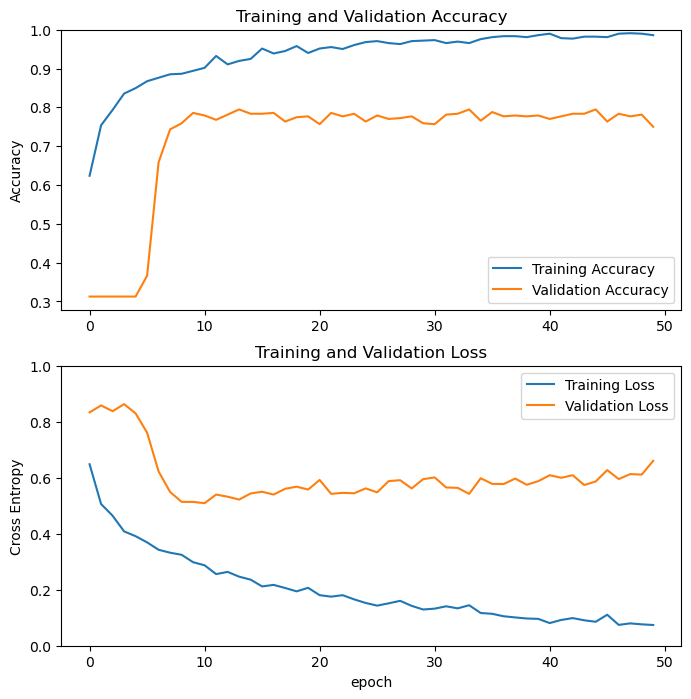

In [19]:
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']

loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [20]:
start=time.time()
test_output_1= model1.evaluate(test_generator, steps=test_generator.samples/test_generator.batch_size, verbose=1)
end=time.time()
print(model1.metrics_names)
print(test_output_1)
print("testing time : "+ str(end-start))

17/17 [==============================] - 5s 273ms/step - loss: 0.6314 - accuracy: 0.7661 - mse: 0.1836
['loss', 'accuracy', 'mse']
[0.6313698887825012, 0.7660818696022034, 0.1835884153842926]
testing time : 5.0659520626068115


In [21]:
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


#Y_pred = model1.predict_generator(validation_generator, 171 // batch_size+1)
Y_pred=model1.predict(test_generator,test_generator.samples//batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
conf=confusion_matrix(test_generator.classes, y_pred)
print(conf)
print('Classification Report')
target_names = ['Gluacoma', 'Normal']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

18/18 [==============================] - 4s 130ms/step
Confusion Matrix
[[59 28]
 [12 72]]
Classification Report
              precision    recall  f1-score   support

    Gluacoma       0.83      0.68      0.75        87
      Normal       0.72      0.86      0.78        84

    accuracy                           0.77       171
   macro avg       0.78      0.77      0.76       171
weighted avg       0.78      0.77      0.76       171



In [22]:
import itertools

Text(0.5, 23.52222222222222, 'Predicted label')

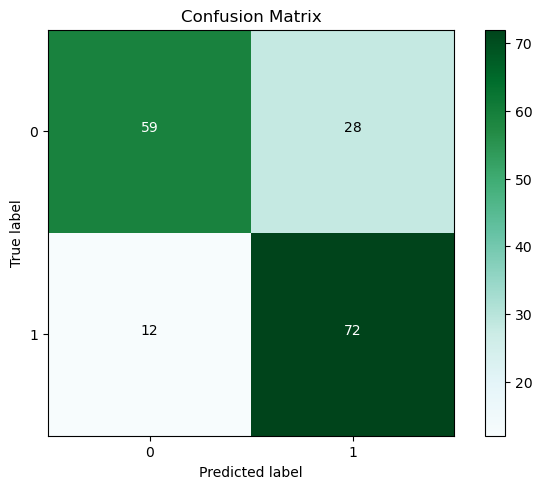

In [23]:
classes = [0, 1]
# plot confusion matrix
plt.imshow(conf, interpolation='nearest', cmap=plt.cm.BuGn)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = conf.max() / 2.
for i, j in itertools.product(range(conf.shape[0]), range(conf.shape[1])):
    plt.text(j, i, format(conf[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

### DenseNet-169

In [24]:
#DenseNet169
import time
epochs =50
batch_size = 10

start = time.time()
history_2 = model2.fit(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=epochs, batch_size =batch_size,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)
end = time.time()
print("Execution Time : ", (end - start))

Epoch 1/50
78/78 [==============================] - 36s 346ms/step - loss: 0.6374 - accuracy: 0.6416 - mse: 0.2232 - val_loss: 0.8002 - val_accuracy: 0.3125 - val_mse: 0.3026
Epoch 2/50
78/78 [==============================] - 22s 280ms/step - loss: 0.5275 - accuracy: 0.7589 - mse: 0.1746 - val_loss: 0.7919 - val_accuracy: 0.3125 - val_mse: 0.2986
Epoch 3/50
78/78 [==============================] - 22s 280ms/step - loss: 0.4594 - accuracy: 0.8163 - mse: 0.1455 - val_loss: 0.7585 - val_accuracy: 0.3125 - val_mse: 0.2824
Epoch 4/50
78/78 [==============================] - 22s 280ms/step - loss: 0.4201 - accuracy: 0.8367 - mse: 0.1307 - val_loss: 0.7207 - val_accuracy: 0.3125 - val_mse: 0.2638
Epoch 5/50
78/78 [==============================] - 22s 279ms/step - loss: 0.4042 - accuracy: 0.8367 - mse: 0.1249 - val_loss: 0.7204 - val_accuracy: 0.3482 - val_mse: 0.2638
Epoch 6/50
78/78 [==============================] - 22s 279ms/step - loss: 0.3916 - accuracy: 0.8495 - mse: 0.1202 - val_loss

In [25]:

model2.save('SavedModels/IEEE/D169.h5')

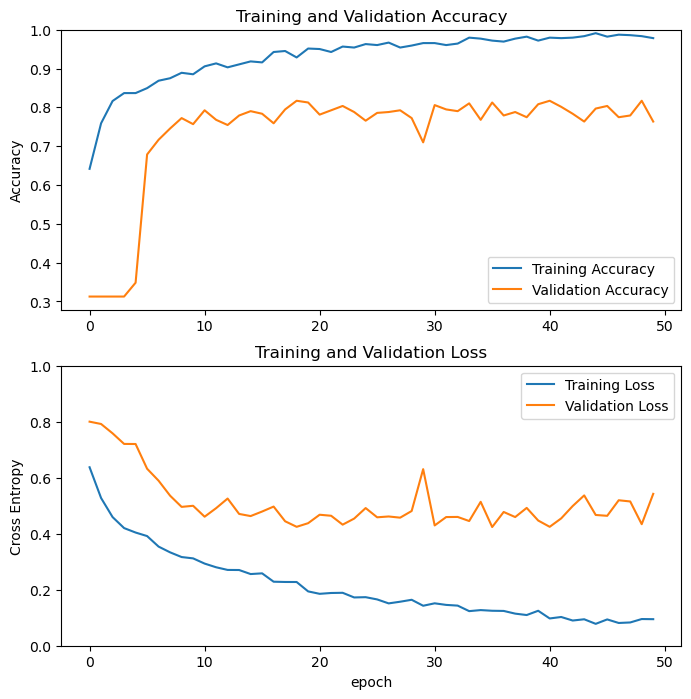

In [26]:
acc = history_2.history['accuracy']
val_acc = history_2.history['val_accuracy']

loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [27]:
start=time.time()
test_output_2= model2.evaluate(test_generator, steps=test_generator.samples/test_generator.batch_size, verbose=1)
end=time.time()
print(model2.metrics_names)
print(test_output_2)
print("testing time : "+ str(end-start))

14/14 [==============================] - 4s 238ms/step - loss: 0.4937 - accuracy: 0.7877 - mse: 0.1586
['loss', 'accuracy', 'mse']
[0.493680864572525, 0.7876712083816528, 0.15862898528575897]
testing time : 3.708768129348755


In [28]:
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


#Y_pred = model1.predict_generator(validation_generator, 171 // batch_size+1)
Y_pred=model2.predict(test_generator,test_generator.samples//batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
conf=confusion_matrix(test_generator.classes, y_pred)
print(conf)
print('Classification Report')
target_names = ['Gluacoma', 'Normal']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

15/15 [==============================] - 4s 145ms/step
Confusion Matrix
[[42 10]
 [21 73]]
Classification Report
              precision    recall  f1-score   support

    Gluacoma       0.67      0.81      0.73        52
      Normal       0.88      0.78      0.82        94

    accuracy                           0.79       146
   macro avg       0.77      0.79      0.78       146
weighted avg       0.80      0.79      0.79       146



Text(0.5, 23.52222222222222, 'Predicted label')

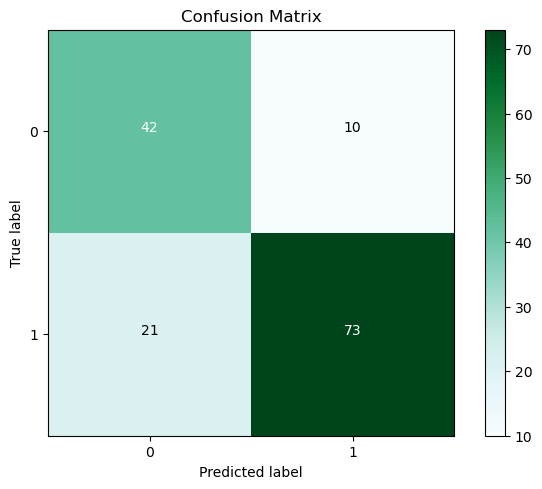

In [29]:
classes = [0, 1]
# plot confusion matrix
plt.imshow(conf, interpolation='nearest', cmap=plt.cm.BuGn)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = conf.max() / 2.
for i, j in itertools.product(range(conf.shape[0]), range(conf.shape[1])):
    plt.text(j, i, format(conf[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

### 3. VGG-19

In [17]:
#Vgg-19
import time
epochs =50
batch_size = 10

start = time.time()
history_3 = model3.fit(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=epochs, batch_size =batch_size,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)
end = time.time()
print("Execution Time : ", (end - start))

Epoch 1/50
78/78 [==============================] - 64s 682ms/step - loss: 0.6200 - accuracy: 0.6811 - mse: 0.2150 - val_loss: 0.6387 - val_accuracy: 0.6875 - val_mse: 0.2231
Epoch 2/50
78/78 [==============================] - 47s 597ms/step - loss: 0.5391 - accuracy: 0.7577 - mse: 0.1786 - val_loss: 0.6321 - val_accuracy: 0.6875 - val_mse: 0.2198
Epoch 3/50
78/78 [==============================] - 47s 597ms/step - loss: 0.4870 - accuracy: 0.7755 - mse: 0.1566 - val_loss: 0.6407 - val_accuracy: 0.7299 - val_mse: 0.2241
Epoch 4/50
78/78 [==============================] - 47s 596ms/step - loss: 0.4558 - accuracy: 0.8087 - mse: 0.1447 - val_loss: 0.6492 - val_accuracy: 0.6116 - val_mse: 0.2288
Epoch 5/50
78/78 [==============================] - 47s 596ms/step - loss: 0.4211 - accuracy: 0.8304 - mse: 0.1305 - val_loss: 0.6057 - val_accuracy: 0.6652 - val_mse: 0.2088
Epoch 6/50
78/78 [==============================] - 47s 596ms/step - loss: 0.3880 - accuracy: 0.8469 - mse: 0.1180 - val_loss

In [18]:
model3.save('SavedModels/IEEE/VGG19.h5')

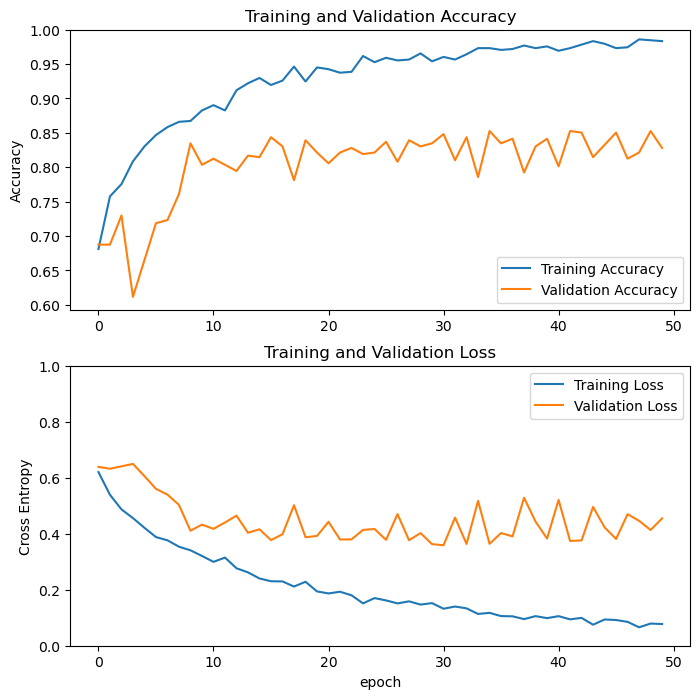

In [19]:
acc = history_3.history['accuracy']
val_acc = history_3.history['val_accuracy']

loss = history_3.history['loss']
val_loss = history_3.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [20]:
start=time.time()
test_output_3= model3.evaluate(test_generator, steps=test_generator.samples/test_generator.batch_size, verbose=1)
end=time.time()
print(model3.metrics_names)
print(test_output_3)
print("testing time : "+ str(end-start))

17/17 [==============================] - 6s 375ms/step - loss: 0.2457 - accuracy: 0.8889 - mse: 0.0760
['loss', 'accuracy', 'mse']
[0.24567504227161407, 0.8888888955116272, 0.07599180191755295]
testing time : 6.544316053390503


In [21]:
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


#Y_pred = model1.predict_generator(validation_generator, 171 // batch_size+1)
Y_pred=model3.predict(test_generator,test_generator.samples//batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
conf=confusion_matrix(test_generator.classes, y_pred)
print(conf)
print('Classification Report')
target_names = ['Gluacoma', 'Normal']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

18/18 [==============================] - 5s 287ms/step
Confusion Matrix
[[83  4]
 [15 69]]
Classification Report
              precision    recall  f1-score   support

    Gluacoma       0.85      0.95      0.90        87
      Normal       0.95      0.82      0.88        84

    accuracy                           0.89       171
   macro avg       0.90      0.89      0.89       171
weighted avg       0.90      0.89      0.89       171



Text(0.5, 23.52222222222222, 'Predicted label')

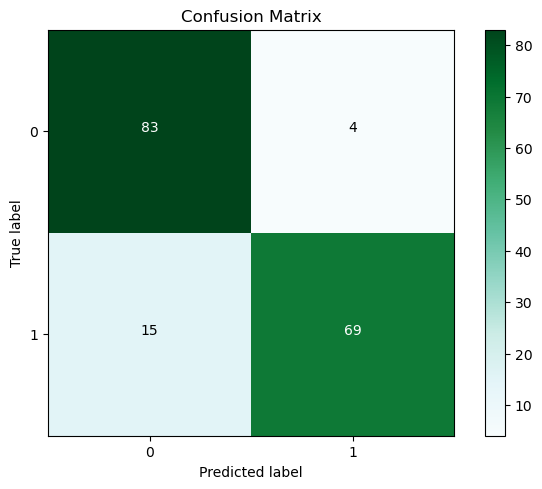

In [22]:
import itertools
classes = [0, 1]
# plot confusion matrix
plt.imshow(conf, interpolation='nearest', cmap=plt.cm.BuGn)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = conf.max() / 2.
for i, j in itertools.product(range(conf.shape[0]), range(conf.shape[1])):
    plt.text(j, i, format(conf[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

### 4. MobileNet V2

In [23]:
#MobileNet 
import time
epochs =50
batch_size = 10

start = time.time()
history_4 = model4.fit(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=epochs, batch_size =batch_size,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)
end = time.time()
print("Execution Time : ", (end - start))

Epoch 1/50
78/78 [==============================] - 22s 222ms/step - loss: 0.5317 - accuracy: 0.7309 - mse: 0.1784 - val_loss: 0.5427 - val_accuracy: 0.7344 - val_mse: 0.1793
Epoch 2/50
78/78 [==============================] - 15s 187ms/step - loss: 0.3640 - accuracy: 0.8622 - mse: 0.1095 - val_loss: 0.4565 - val_accuracy: 0.7790 - val_mse: 0.1455
Epoch 3/50
78/78 [==============================] - 14s 184ms/step - loss: 0.3121 - accuracy: 0.8954 - mse: 0.0912 - val_loss: 0.3830 - val_accuracy: 0.8326 - val_mse: 0.1167
Epoch 4/50
78/78 [==============================] - 14s 183ms/step - loss: 0.2565 - accuracy: 0.9209 - mse: 0.0703 - val_loss: 0.3407 - val_accuracy: 0.8504 - val_mse: 0.1020
Epoch 5/50
78/78 [==============================] - 14s 184ms/step - loss: 0.2301 - accuracy: 0.9337 - mse: 0.0617 - val_loss: 0.3292 - val_accuracy: 0.8705 - val_mse: 0.0990
Epoch 6/50
78/78 [==============================] - 14s 184ms/step - loss: 0.1853 - accuracy: 0.9477 - mse: 0.0466 - val_loss

In [24]:
model4.save('SavedModels/IEEE/MobileNet.h5')

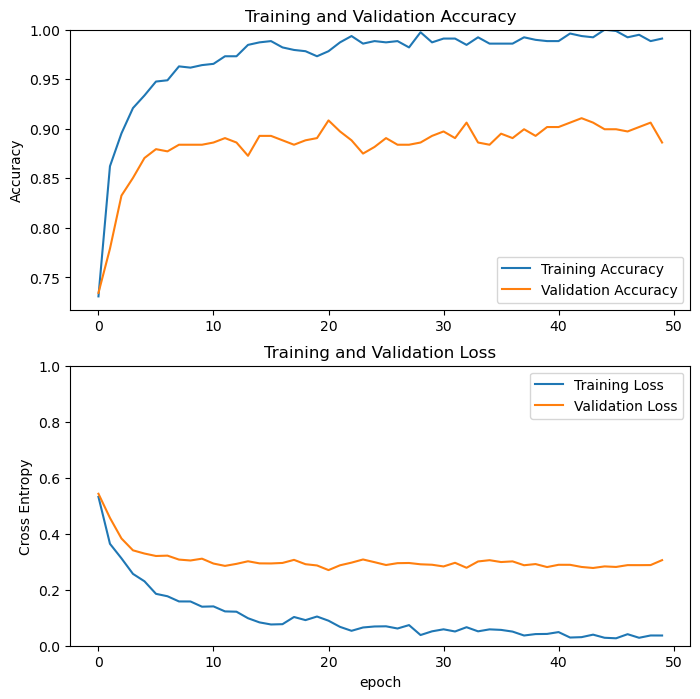

In [25]:
acc = history_4.history['accuracy']
val_acc = history_4.history['val_accuracy']

loss = history_4.history['loss']
val_loss = history_4.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [26]:
start=time.time()
test_output_4= model4.evaluate(test_generator, steps=test_generator.samples/test_generator.batch_size, verbose=1)
end=time.time()
print(model4.metrics_names)
print(test_output_4)
print("testing time : "+ str(end-start))

17/17 [==============================] - 3s 150ms/step - loss: 0.3396 - accuracy: 0.8538 - mse: 0.0994
['loss', 'accuracy', 'mse']
[0.33960098028182983, 0.8538011908531189, 0.09936555474996567]
testing time : 2.691270589828491


In [27]:
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


#Y_pred = model1.predict_generator(validation_generator, 171 // batch_size+1)
Y_pred=model4.predict(test_generator,test_generator.samples//batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
conf=confusion_matrix(test_generator.classes, y_pred)
print(conf)
print('Classification Report')
target_names = ['Gluacoma', 'Normal']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

18/18 [==============================] - 3s 102ms/step
Confusion Matrix
[[74 13]
 [12 72]]
Classification Report
              precision    recall  f1-score   support

    Gluacoma       0.86      0.85      0.86        87
      Normal       0.85      0.86      0.85        84

    accuracy                           0.85       171
   macro avg       0.85      0.85      0.85       171
weighted avg       0.85      0.85      0.85       171



Text(0.5, 23.52222222222222, 'Predicted label')

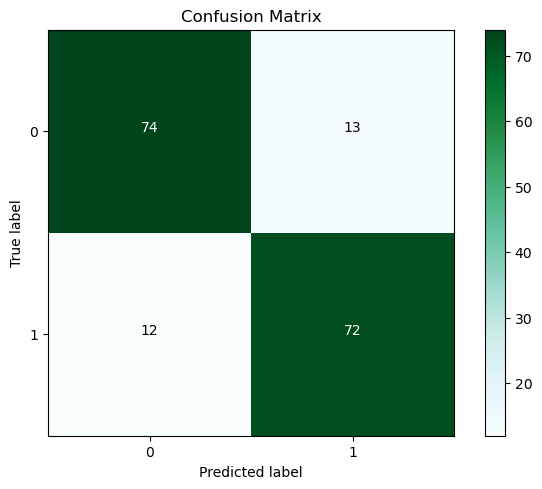

In [28]:
classes = [0, 1]
# plot confusion matrix
plt.imshow(conf, interpolation='nearest', cmap=plt.cm.BuGn)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = conf.max() / 2.
for i, j in itertools.product(range(conf.shape[0]), range(conf.shape[1])):
    plt.text(j, i, format(conf[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

## ResNet50

In [29]:
#ResNet 50
import time
epochs =50
batch_size = 10

start = time.time()
history_5 = model5.fit(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=epochs, batch_size =batch_size,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)
end = time.time()
print("Execution Time : ", (end - start))

Epoch 1/50
78/78 [==============================] - 31s 344ms/step - loss: 0.6645 - accuracy: 0.6161 - mse: 0.2358 - val_loss: 0.6475 - val_accuracy: 0.6875 - val_mse: 0.2273
Epoch 2/50
78/78 [==============================] - 24s 308ms/step - loss: 0.6414 - accuracy: 0.6798 - mse: 0.2247 - val_loss: 0.6204 - val_accuracy: 0.6875 - val_mse: 0.2145
Epoch 3/50
78/78 [==============================] - 24s 309ms/step - loss: 0.6199 - accuracy: 0.6837 - mse: 0.2145 - val_loss: 0.6464 - val_accuracy: 0.6875 - val_mse: 0.2242
Epoch 4/50
78/78 [==============================] - 24s 309ms/step - loss: 0.6058 - accuracy: 0.6888 - mse: 0.2083 - val_loss: 0.7223 - val_accuracy: 0.6875 - val_mse: 0.2456
Epoch 5/50
78/78 [==============================] - 24s 309ms/step - loss: 0.5914 - accuracy: 0.7092 - mse: 0.2015 - val_loss: 0.8208 - val_accuracy: 0.6875 - val_mse: 0.2647
Epoch 6/50
78/78 [==============================] - 24s 309ms/step - loss: 0.5739 - accuracy: 0.7462 - mse: 0.1935 - val_loss

In [36]:
model5.save('SavedModels/IEEE/ResNet.h5')

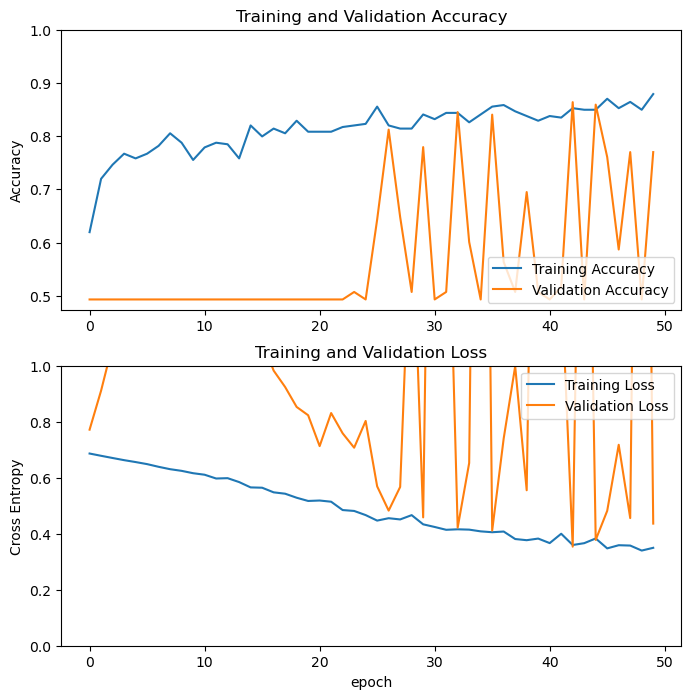

In [37]:
acc = history_5.history['accuracy']
val_acc = history_5.history['val_accuracy']

loss = history_5.history['loss']
val_loss = history_5.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [38]:
start=time.time()
test_output_5= model5.evaluate(test_generator, steps=test_generator.samples/test_generator.batch_size, verbose=1)
end=time.time()
print(model5.metrics_names)
print(test_output_5)
print("testing time : "+ str(end-start))

14/14 [==============================] - 3s 200ms/step - loss: 0.5684 - accuracy: 0.7123 - mse: 0.1930
['loss', 'accuracy', 'mse']
[0.5683662295341492, 0.7123287916183472, 0.1929859071969986]
testing time : 2.993497610092163


In [39]:
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


#Y_pred = model1.predict_generator(validation_generator, 171 // batch_size+1)
Y_pred=model5.predict(test_generator,test_generator.samples//batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
conf=confusion_matrix(test_generator.classes, y_pred)
print(conf)
print('Classification Report')
target_names = ['Gluacoma', 'Normal']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

15/15 [==============================] - 3s 141ms/step
Confusion Matrix
[[51  1]
 [41 53]]
Classification Report
              precision    recall  f1-score   support

    Gluacoma       0.55      0.98      0.71        52
      Normal       0.98      0.56      0.72        94

    accuracy                           0.71       146
   macro avg       0.77      0.77      0.71       146
weighted avg       0.83      0.71      0.71       146



Text(0.5, 23.52222222222222, 'Predicted label')

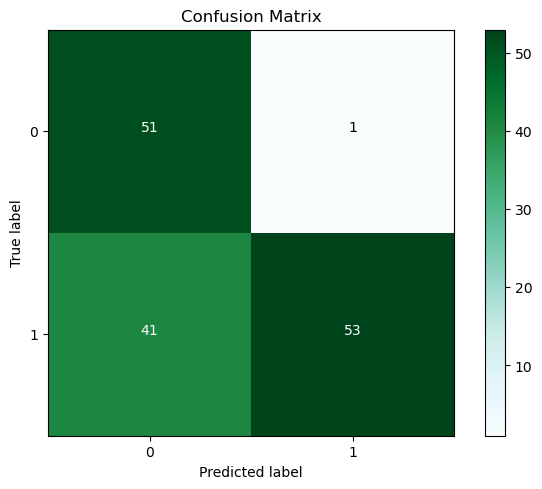

In [40]:
classes = [0, 1]
# plot confusion matrix
plt.imshow(conf, interpolation='nearest', cmap=plt.cm.BuGn)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = conf.max() / 2.
for i, j in itertools.product(range(conf.shape[0]), range(conf.shape[1])):
    plt.text(j, i, format(conf[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

### 6. Inception V3

In [30]:
#Inception V3
import time
epochs =50
batch_size = 10

start = time.time()
history_6 = model6.fit(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=epochs, batch_size =batch_size,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)
end = time.time()
print("Execution Time : ", (end - start))

Epoch 1/50
78/78 [==============================] - 28s 283ms/step - loss: 0.6289 - accuracy: 0.6480 - mse: 0.2188 - val_loss: 0.7837 - val_accuracy: 0.3415 - val_mse: 0.2944
Epoch 2/50
78/78 [==============================] - 17s 219ms/step - loss: 0.4514 - accuracy: 0.8074 - mse: 0.1442 - val_loss: 0.7052 - val_accuracy: 0.4978 - val_mse: 0.2568
Epoch 3/50
78/78 [==============================] - 17s 219ms/step - loss: 0.3821 - accuracy: 0.8482 - mse: 0.1168 - val_loss: 0.5937 - val_accuracy: 0.6942 - val_mse: 0.2041
Epoch 4/50
78/78 [==============================] - 17s 219ms/step - loss: 0.3320 - accuracy: 0.8763 - mse: 0.0982 - val_loss: 0.5674 - val_accuracy: 0.7031 - val_mse: 0.1918
Epoch 5/50
78/78 [==============================] - 17s 219ms/step - loss: 0.2667 - accuracy: 0.9235 - mse: 0.0720 - val_loss: 0.5670 - val_accuracy: 0.7188 - val_mse: 0.1897
Epoch 6/50
78/78 [==============================] - 17s 219ms/step - loss: 0.2649 - accuracy: 0.9222 - mse: 0.0729 - val_loss

In [36]:
model6.save('SavedModels/IEEE/Inception.h5')

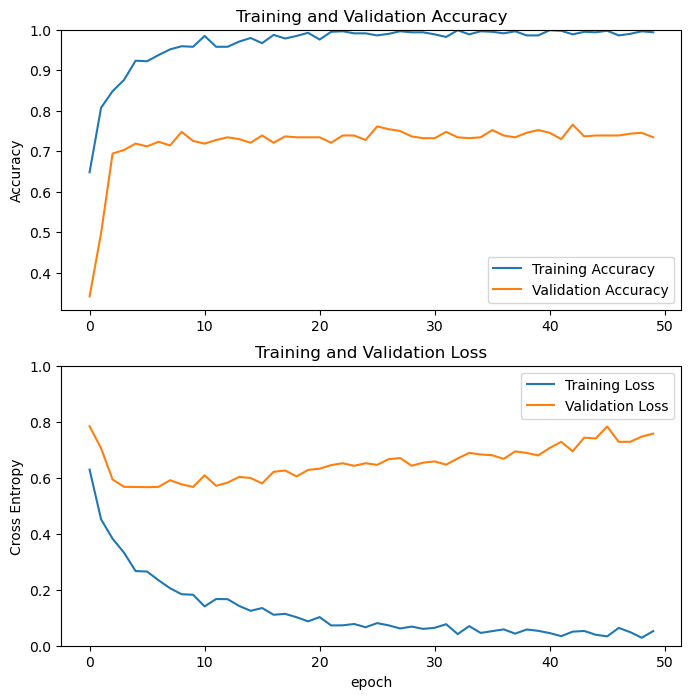

In [37]:
acc = history_6.history['accuracy']
val_acc = history_6.history['val_accuracy']

loss = history_6.history['loss']
val_loss = history_6.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [38]:
start=time.time()
test_output_6= model6.evaluate(test_generator, steps=test_generator.samples/test_generator.batch_size, verbose=1)
end=time.time()
print(model6.metrics_names)
print(test_output_6)
print("testing time : "+ str(end-start))

17/17 [==============================] - 2s 118ms/step - loss: 1.0309 - accuracy: 0.7018 - mse: 0.2415
['loss', 'accuracy', 'mse']
[1.0309317111968994, 0.7017543911933899, 0.24148809909820557]
testing time : 2.359253406524658


In [39]:
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


#Y_pred = model1.predict_generator(validation_generator, 171 // batch_size+1)
Y_pred=model6.predict(test_generator,test_generator.samples//batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
conf=confusion_matrix(test_generator.classes, y_pred)
print(conf)
print('Classification Report')
target_names = ['Gluacoma', 'Normal']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

18/18 [==============================] - 2s 122ms/step
Confusion Matrix
[[64 23]
 [28 56]]
Classification Report
              precision    recall  f1-score   support

    Gluacoma       0.70      0.74      0.72        87
      Normal       0.71      0.67      0.69        84

    accuracy                           0.70       171
   macro avg       0.70      0.70      0.70       171
weighted avg       0.70      0.70      0.70       171



Text(0.5, 23.52222222222222, 'Predicted label')

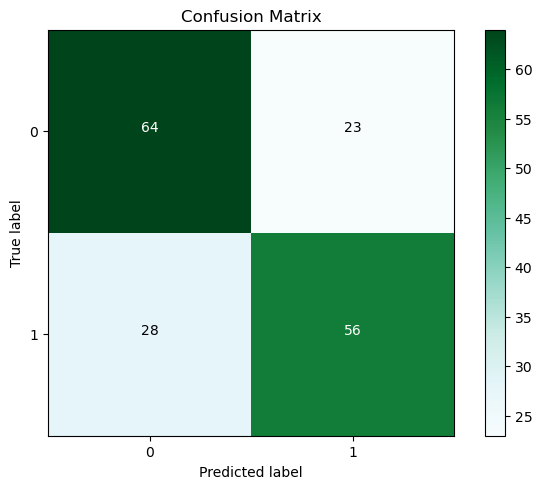

In [40]:
classes = [0, 1]
# plot confusion matrix
plt.imshow(conf, interpolation='nearest', cmap=plt.cm.BuGn)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = conf.max() / 2.
for i, j in itertools.product(range(conf.shape[0]), range(conf.shape[1])):
    plt.text(j, i, format(conf[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')